In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import epidemic_model_classes_numba as epi_mod
from ABC_backend_numba import *
from data_loading import LoadData
from proj_consts import ProjectConsts

log_paths = ["../logs/log2021-03-22_18-10-19_DF_SEIRD_True_10/", "../logs/log2021-03-22_10-05-12_DF_SEIRD_True_20/", 
             "../logs/log2021-03-22_08-08-44_DF_SEIRD_True_30/", "../logs/log2021-03-23_12-17-16_DF_SEIRD_True_40/"]
# log_labels = ["Flat prior", "Last window posterior"]

data_path = open("data_path.txt", "r").read()
df_brazil_state_cases = pd.read_csv(data_path)

In [53]:
locations = open(r"locationsIN.txt", "r").read().split("\n")[:-1]
# models = open(r"modelsIN.txt", "r").read().split("\n")[:1]
models = ["SEIRD2"]#, "SEIHRD", "SEIARD"]
print(locations)
print(models)

['DF']
['SEIRD2']


In [54]:
n_post = 0
for file in os.listdir(log_paths[0]):
    
    if ("Posterior" in file):
        n_post += 1
        
print(n_post)

5


In [55]:
day_step = 5
day_set_size = 40
val_set_size = 10
day_start = 0

data = LoadData.getBrazilStateDataFrame(df_brazil_state_cases, locations[0])
x_total = np.array(data.day, dtype=np.float64)

days_sets_set = []
days_list = []

for i in range(len(log_paths)):
    
    day_set_size = int(log_paths[i][-3:-1])
    days = []
    
    n_sets = int((len(data)-day_set_size-val_set_size) // day_step)
    
    for l in range(n_sets):

        if (l*day_step+day_set_size >= day_start):

            days.append(l*day_step+day_set_size)

    days_sets = []

    if (day_step == 0):

        days_sets.append(x_total)

    else:

        for k in range((len(x_total)-day_set_size-val_set_size)//day_step):

            days_sets.append(x_total[day_step*k:day_step*k+day_set_size])

    for k in range(len(days_sets)):

        if (days_sets[k][-1] >= day_start+x_total[0]-1):

            start_idx = k
            break
            
    days_sets_set.append(days_sets)
    days_list.append(days)

In [56]:
from scipy.optimize import curve_fit

def fit_comb(pred, *p):
        
    p = np.array(p)
    
    return np.sum(p.reshape((-1,1))*pred, axis=0).T
#     return (np.sum(p.reshape((-1,1))*pred, axis=0)/np.sum(p)).T

In [57]:
rmsd_train_list = np.zeros((len(log_paths), len(days)))
rmsd_val_list = np.zeros((len(log_paths), len(days)))
rmsd_val_avg = np.zeros((len(days)))
rmsd_val_comb = np.zeros((len(days)))

min_day_set_size = int(log_paths[0][-3:-1])

pred_val = np.zeros((len(log_paths), len(days), 2, val_set_size))
pred_avg = np.zeros((len(days), 2, val_set_size))
pred_train_min_size = np.zeros((len(log_paths), len(days), 2, min_day_set_size))
dat_y_val = np.zeros((len(days), 2, val_set_size))
x_min_size = np.zeros((len(days), min_day_set_size))
y_min_size = np.zeros((len(days), 2, min_day_set_size))
x_val_set = np.zeros((len(days), val_set_size))
y_val_set = np.zeros((len(days), 2, val_set_size))

rmsd_train_min_size_avg = np.zeros((len(log_paths), len(days)))
rmsd_train_min_size_comb = np.zeros((len(log_paths), len(days)))

model = getattr(epi_mod, models[0])

for idx in range(len(days)):
    for log in range(len(log_paths)):
        days_sets = days_sets_set[log]
        idx_fix = days_list[log].index(days_list[-1][0])
        days_idx = idx+idx_fix
        
        filepath =  f"{log_paths[log]}Posterior{n_post}/{locations[0]}/{models[0]}/{days_list[log][days_idx]}_days"
        p = np.genfromtxt(filepath+"/best_params.txt")
        weights = np.array([1, 1], dtype=np.float64)
        
        x = days_sets[days_idx]
        x_val = (days_sets[days_idx]+val_set_size)[-val_set_size:]
        x_dat_val = np.concatenate((x, x_val))
        y = np.array(data[["confirmed", "dead"]].T, dtype=np.float64)[:,days_sets[days_idx].astype(np.int)-int(days_sets[0][0])]
        y_val = np.array(data[["confirmed", "dead"]].T, dtype=np.float64)[:,(days_sets[days_idx]+val_set_size)[-val_set_size:].astype(np.int)-int(days_sets[0][0])]
        y_dat_val = np.concatenate((y, y_val), axis=1)
        
        y0 = np.zeros(model.ncomp, dtype=np.float64)
        y0[-1] = data.loc[int(days_sets[days_idx][0]-days_sets[0][0]),["dead"]]
        y0[-2] = data.loc[int(days_sets[days_idx][0]-days_sets[0][0]),["confirmed"]]-y0[-1]
        
        if log == 0:
            x_min_size[idx] = np.copy(x)
            y_min_size[idx] = np.copy(y)
            y0_min_size = np.copy(y0)
            x_val_set[idx] = x_val
            y_val_set[idx] = y_val
        
        pred_train_min_size[log, idx] = model.infected_dead(x, p, y0)[:,-min_day_set_size:]
        pred_val[log, idx] = model.infected_dead(x_dat_val, p, y0)[:,-val_set_size:]
        
        rmsd_train_list[log, idx] = distance(y, model.infected_dead(x, p, y0), weights)
        rmsd_val_list[log, idx] = distance(y_dat_val[:,-val_set_size:], pred_val[log, idx], weights)
        
#         rmsd_train_min_size[log, idx] = distance(y_min_size[idx], np.average(pred_train_min_size[:,idx], axis=0, weights=1/rmsd_train_list[:, idx])[:1], weights)
    
    dat_y_val[idx] = y_val

    pred_avg[idx] = np.average(pred_val[:,idx], axis=0, weights=1/rmsd_train_list[:, idx])
    rmsd_val_avg[idx] = distance(y_val[:1], pred_avg[idx][:1], weights)
    
    comb_params = curve_fit(fit_comb, pred_train_min_size[:,idx,0], y[0,-min_day_set_size:], p0=1/rmsd_train_list[:, idx], bounds=(np.zeros(4), np.ones(4)))[0]
    rmsd_val_comb[idx] = distance(y_val[:1], fit_comb(pred_val[:,idx,0], comb_params).reshape(1,-1))
    
#     if idx > 0:
#         comb_params = curve_fit(fit_comb, pred_val[:,idx-1,0], y_val_set[idx-1,0], p0=1/rmsd_train_list[:, idx], bounds=(np.zeros(5), np.ones(5)))[0]
#         rmsd_val_comb[idx] = distance(y_val[:1], fit_comb(pred_val[:,idx,0], comb_params).reshape(1,-1))
#     else:
#         comb_params = curve_fit(fit_comb, pred_train_min_size[:,idx,0], y[0,-min_day_set_size:], p0=1/rmsd_train_list[:, idx], bounds=(np.zeros(5), np.ones(5)))[0]
#         rmsd_val_comb[idx] = distance(y_val[:1], fit_comb(pred_val[:,idx,0], comb_params).reshape(1,-1))

    print(f"\r{days_idx+1}/{len(days)}", end="")

63/63

[ 1.88186337 -2.42886376  0.4980349   1.03734442]
[0.99858341 0.         0.         0.        ]


Text(0.5, 0, 'Days')

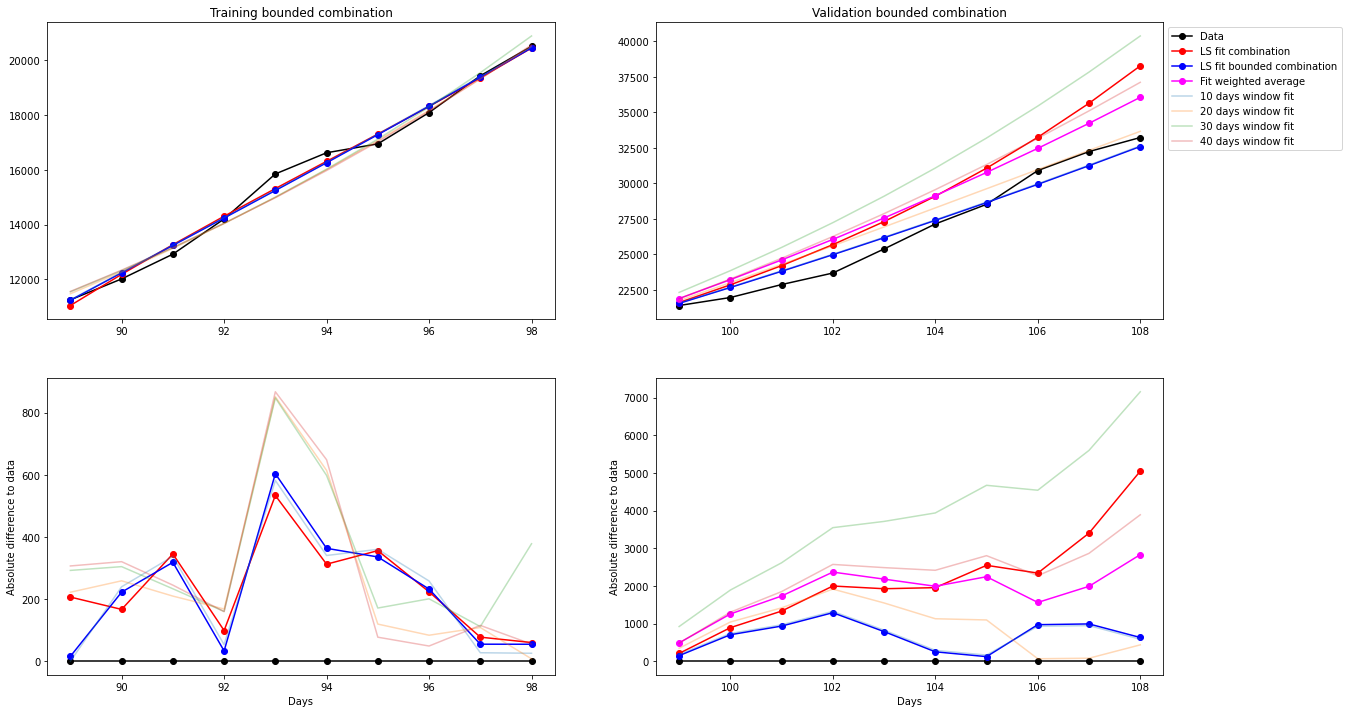

In [58]:
window = 10

p, pcov = curve_fit(fit_comb, pred_train_min_size[:,window,0], y_min_size[window,0], p0=np.ones(len(log_paths)))
print(p.round(10))

p2, pcov = curve_fit(fit_comb, pred_train_min_size[:,window,0], y_min_size[window,0], p0=np.ones(len(log_paths)), bounds=(np.zeros(4), np.ones(4)))
print(p2.round(10))

plt.subplots(2,2, figsize=(20,12))
plt.subplot(2,2,1)
plt.plot(x_min_size[window], y_min_size[window,0], "-o", c="k", label="Data")
plt.plot(x_min_size[window], fit_comb(pred_train_min_size[:,window,0], p), "-o", c="r", label="LS fit combination")
plt.plot(x_min_size[window], fit_comb(pred_train_min_size[:,window,0], p2), "-o", c="b", label="LS fit bounded combination")
# error["LS"] = np.abs(y_min_size[window,0]-fit_comb(pred_train_min_size[:,window,0], p2))
for i in range(len(log_paths)):
    plt.plot(x_min_size[window], pred_train_min_size[:,window,0][i], c=f"C{i}", alpha=0.3, label=f"{log_paths[i][-3:-1]} days window fit")
#     error[log_paths[i][-3:-1]] = np.abs(y_min_size[window,0]-pred_train_min_size[:,window,0][i])
plt.title("Training bounded combination")
# plt.ylim(y_min_size[window,0].min()*0.95, y_min_size[window,0].max()*1.05)
# plt.legend(bbox_to_anchor=(1,1))

plt.subplot(2,2,2)
plt.plot(x_val_set[window], y_val_set[window,0], "-o", c="k", label="Data")
plt.plot(x_val_set[window], fit_comb(pred_val[:,window,0], p), "-o", c="r", label="LS fit combination")
plt.plot(x_val_set[window], fit_comb(pred_val[:,window,0], p2), "-o", c="b", label="LS fit bounded combination")
plt.plot(x_val_set[window], pred_avg[window,0], "-o", c="magenta", label="Fit weighted average")
for i in range(len(log_paths)):
    plt.plot(x_val_set[window], pred_val[:,window,0][i], alpha=0.3, label=f"{log_paths[i][-3:-1]} days window fit")
plt.title("Validation bounded combination")
# plt.ylim(y_min_size[window,0].min()*0.95, y_min_size[window,0].max()*1.05)
plt.legend(bbox_to_anchor=(1,1))

plt.subplot(2,2,3)
plt.plot(x_min_size[window], 0*y_min_size[window,0], "-o", c="k", label="Data")
plt.plot(x_min_size[window], np.abs(y_min_size[window,0]-fit_comb(pred_train_min_size[:,window,0], p)), "-o", c="r", label="LS fit combination")
plt.plot(x_min_size[window], np.abs(y_min_size[window,0]-fit_comb(pred_train_min_size[:,window,0], p2)), "-o", c="b", label="LS fit bounded combination")
# error["LS"] = np.abs(y_min_size[window,0]-fit_comb(pred_train_min_size[:,window,0], p2))
for i in range(len(log_paths)):
    plt.plot(x_min_size[window], np.abs(y_min_size[window,0]-pred_train_min_size[:,window,0][i]), c=f"C{i}", alpha=0.3, label=f"{log_paths[i][-3:-1]} days window fit")
#     error[log_paths[i][-3:-1]] = np.abs(y_min_size[window,0]-pred_train_min_size[:,window,0][i])
plt.ylabel("Absolute difference to data")
plt.xlabel("Days")
    
plt.subplot(2,2,4)
plt.plot(x_val_set[window], 0*y_val_set[window,0], "-o", c="k", label="Data")
plt.plot(x_val_set[window], np.abs(y_val_set[window,0]-fit_comb(pred_val[:,window,0], p)), "-o", c="r", label="LS fit combination")
plt.plot(x_val_set[window], np.abs(y_val_set[window,0]-fit_comb(pred_val[:,window,0], p2)), "-o", c="b", label="LS fit bounded combination")
plt.plot(x_val_set[window], np.abs(y_val_set[window,0]-pred_avg[window,0]), "-o", c="magenta", label="Fit weighted average")
for i in range(len(log_paths)):
    plt.plot(x_val_set[window], np.abs(y_val_set[window,0]-pred_val[:,window,0][i]), alpha=0.3, label=f"{log_paths[i][-3:-1]} days window fit")
plt.ylabel("Absolute difference to data")
plt.xlabel("Days")
# plt.ylim(0)#y_min_size[window,0].min()*0.95, y_min_size[window,0].max()*1.05)
# plt.legend(bbox_to_anchor=(1,1))

# error.round(3)

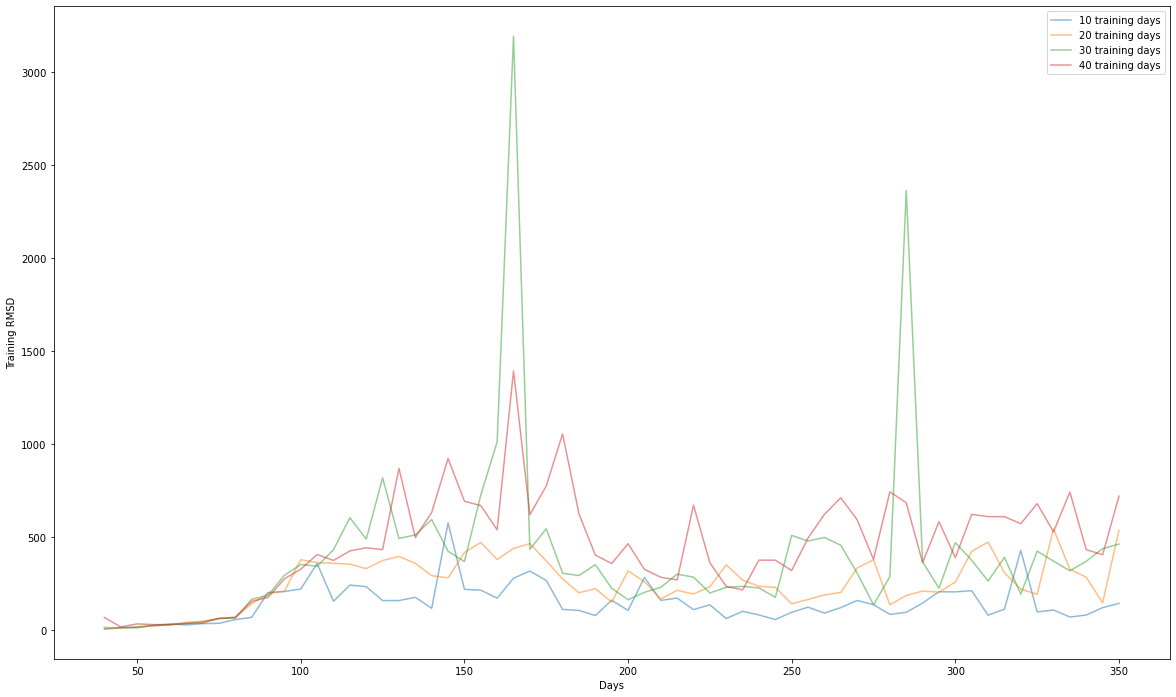

In [59]:
plt.figure(figsize=(20,12))
for i in range(len(log_paths)):
    plt.plot(days, rmsd_train_list[i], alpha=0.5, label=log_paths[i][-3:-1]+" training days")
plt.xlabel("Days")
plt.ylabel("Training RMSD")
plt.legend()
plt.show()

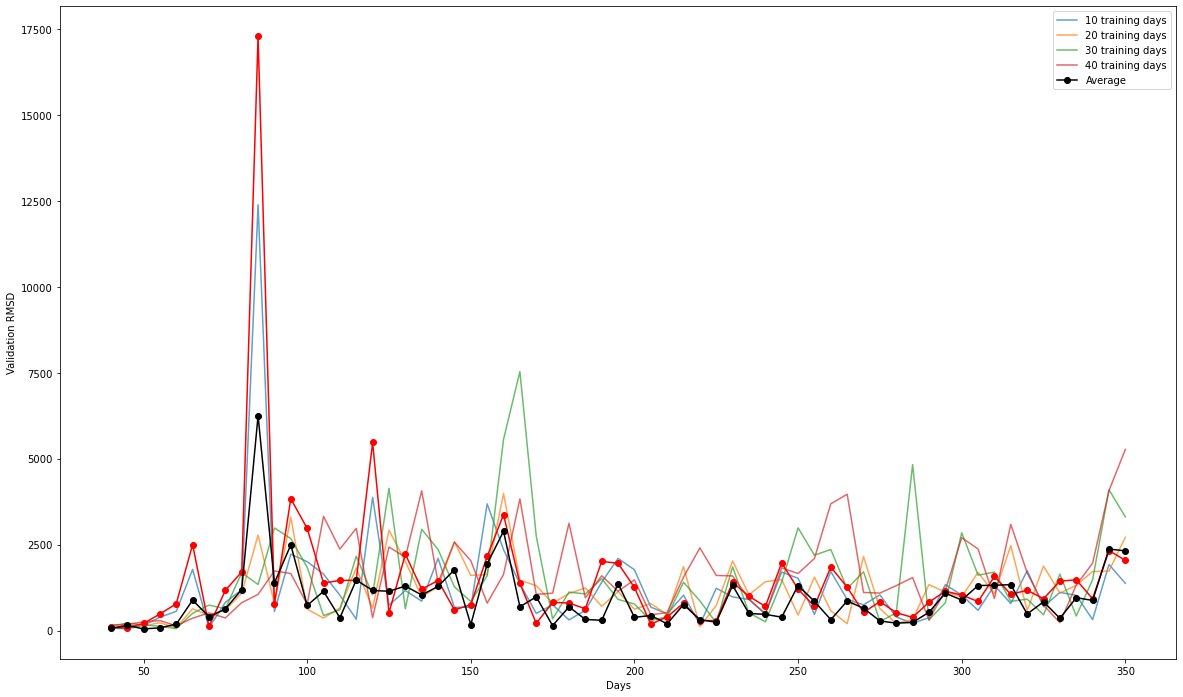

In [60]:
plt.figure(figsize=(20,12))
for i in range(4):
    plt.plot(days, rmsd_val_list[i], alpha=0.7, label=log_paths[i][-3:-1]+" training days")
plt.plot(days, rmsd_val_comb, "-o", c="r")
plt.xlabel("Days")
plt.ylabel("Validation RMSD")
plt.plot(days, rmsd_val_avg, "-o", c="k", label="Average")
plt.legend()
plt.show()

In [61]:
len(np.where(rmsd_val_avg<np.min(rmsd_val_list, axis=0))[0])/len(rmsd_val_avg)

0.2698412698412698

In [62]:
len(np.where(rmsd_val_avg<rmsd_val_comb)[0])/len(rmsd_val_avg)

0.746031746031746

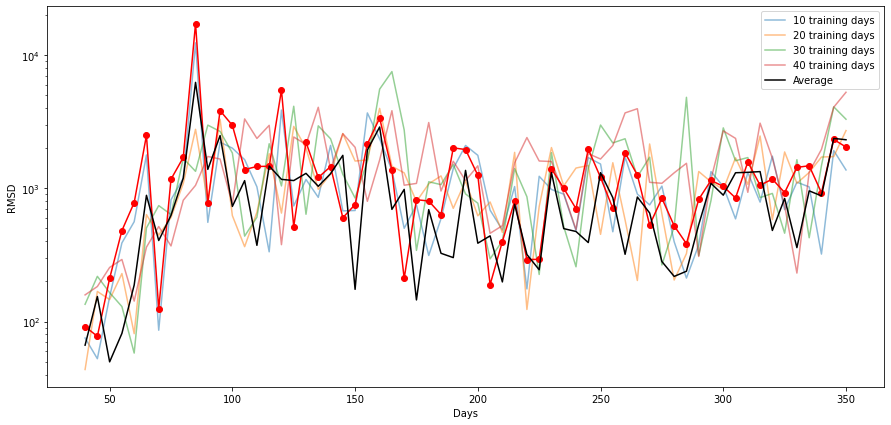

In [63]:
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    plt.plot(days, rmsd_val_list[i], alpha=0.5, label=log_paths[i][-3:-1]+" training days")
plt.xlabel("Days")
plt.ylabel("RMSD")
plt.plot(days, rmsd_val_comb, "-o", c="r")
plt.plot(days, rmsd_val_avg, c="k", label="Average")
plt.legend()
plt.yscale("log")
plt.show()

In [64]:
len(np.where(rmsd_val_avg < np.min(rmsd_val_list, axis=0))[0])/len(rmsd_val_avg)*100

26.984126984126984

Best Validation RMSD for 10 days window: 33.3%
Best Validation RMSD for 20 days window: 23.8%
Best Validation RMSD for 30 days window: 25.4%
Best Validation RMSD for 40 days window: 17.5%


Text(0, 0.5, 'Training window size with best validation RMSD')

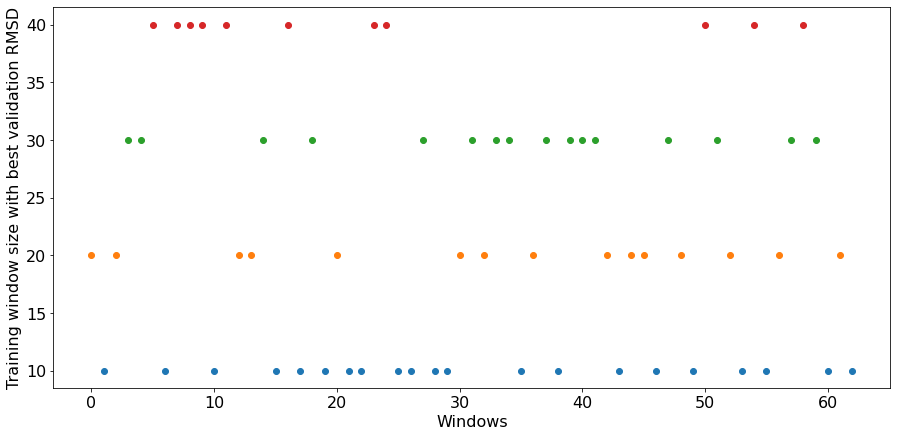

In [65]:
plt.rcParams.update({'font.size': 16})
# rmsd_train_min = np.array(np.where(rmsd_train_list == np.min(rmsd_train_list, axis=0)))
# plt.figure(figsize=(15,7))
# for i in range(len(log_paths)):
#     plt.scatter(rmsd_train_min[1][np.where(rmsd_train_min[0] == i)[0]], [int(log_paths[i][-3:-1]) for j in range(len(np.where(rmsd_train_min[0] == i)[0]))])
#     print(f"Best Train RMSD for {log_paths[i][-3:-1]} days window: {len(np.where(rmsd_train_min[0] == i)[0])/len(days)*100:.1f}%")
# plt.xlabel("Days")
# plt.ylabel("Windows with best ")

rmsd_val_min = np.array(np.where(rmsd_val_list == np.min(rmsd_val_list, axis=0)))
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    plt.scatter(rmsd_val_min[1][np.where(rmsd_val_min[0] == i)[0]], [int(log_paths[i][-3:-1]) for j in range(len(np.where(rmsd_val_min[0] == i)[0]))])
    print(f"Best Validation RMSD for {log_paths[i][-3:-1]} days window: {len(np.where(rmsd_val_min[0] == i)[0])/len(days)*100:.1f}%")
plt.xlabel("Windows")
plt.ylabel("Training window size with best validation RMSD")

In [66]:
tols = np.zeros((len(log_paths), len(days_list[0]), n_post))
tol_median = np.zeros((len(log_paths), len(days_list[0]), n_post))
tol_bounds = np.zeros((len(log_paths), len(days_list[0]), n_post, 2))

for i in range(len(log_paths)):
    for j in range(len(days_list[i])):
        for k in range(0, n_post):
            
            filepath =  f"{log_paths[i]}Posterior{k+1}/{locations[0]}/{models[0]}/{days_list[i][j]}_days"
            
            logfile = open(filepath+"/SEIRD_log.out").read().split("\n")
            post_tols = np.genfromtxt(filepath+"/post.txt")[:,-1]
            for line in logfile:
                
                if "Tolerance:" in line:
#                     print("\t"+line.split(" ")[-1])
                    tols[i,j,k] = line.split(" ")[-1]
                    tol_median[i,j,k] = np.median(post_tols)
                    tol_bounds[i,j,k,0] = np.median(post_tols)-np.min(post_tols)
                    tol_bounds[i,j,k,1] = np.max(post_tols)-np.median(post_tols)
                    break
            
            print(f"\r{i+1}/{len(log_paths)}, {j+1}/{len(days_list[i])}, {k+1}/{n_post}", end="")

4/4, 63/63, 5/5

In [67]:
log_paths = ["../logs/sdumont/log2021-04-27_16-29-54_DF_SEIRD_False_10_noise_10/", "../logs/sdumont/log2021-04-27_15-08-42_DF_SEIRD_False_20_noise_10/", 
             "../logs/sdumont/log2021-04-27_14-42-33_DF_SEIRD_False_30_noise_10/", "../logs/sdumont/log2021-04-27_16-12-43_DF_SEIRD_False_40_noise_10/"]
# log_labels = ["Flat prior", "Last window posterior"]

data_path = open("data_path.txt", "r").read()
df_brazil_state_cases = pd.read_csv(data_path)

In [68]:
locations = open(r"locationsIN.txt", "r").read().split("\n")[:-1]
# models = open(r"modelsIN.txt", "r").read().split("\n")[:1]
models = ["SEIRD"]#, "SEIHRD", "SEIARD"]
print(locations)
print(models)

['DF']
['SEIRD']


In [69]:
n_post = 0
for file in os.listdir(log_paths[0]):
    
    if ("Posterior" in file):
        n_post += 1
        
print(n_post)

10


In [70]:
day_step = 5
day_set_size = 40
val_set_size = 10
day_start = 0

data = LoadData.getBrazilStateDataFrame(df_brazil_state_cases, locations[0])
x_total = np.array(data.day, dtype=np.float64)

days_sets_set = []
days_list = []

for i in range(len(log_paths)):
    
    day_set_size = int(log_paths[i][-12:-10])
    days = []
    
    n_sets = int((len(data)-day_set_size-val_set_size) // day_step)
    
    for l in range(n_sets):

        if (l*day_step+day_set_size >= day_start):

            days.append(l*day_step+day_set_size)

    days_sets = []

    if (day_step == 0):

        days_sets.append(x_total)

    else:

        for k in range((len(x_total)-day_set_size-val_set_size)//day_step):

            days_sets.append(x_total[day_step*k:day_step*k+day_set_size])

    for k in range(len(days_sets)):

        if (days_sets[k][-1] >= day_start+x_total[0]-1):

            start_idx = k
            break
            
    days_sets_set.append(days_sets)
    days_list.append(days)

In [71]:
rmsd_train_list = np.zeros((len(log_paths), len(days)))
rmsd_val_list = np.zeros((len(log_paths), len(days)))
rmsd_val_avg2 = np.zeros((len(days)))
error = np.zeros((len(log_paths), len(days), 2, val_set_size))

pred_val = np.zeros((len(log_paths), len(days), 2, val_set_size))
dat_y_val = np.zeros((len(days), 2, val_set_size))

model = getattr(epi_mod, models[0])

for idx in range(len(days)):
    for log in range(len(log_paths)):
        
        days_sets = days_sets_set[log]
        idx_fix = days_list[log].index(days_list[-1][0])
        days_idx = idx+idx_fix
        
        filepath =  f"../logs/{log_paths[log]}Posterior{n_post}/{locations[0]}/{models[0]}/{days_list[log][days_idx]}_days"
        p = np.genfromtxt(filepath+"/best_params.txt")
        weights = np.array([1, 1], dtype=np.float64)
        
        x = days_sets[days_idx]
        x_val = (days_sets[days_idx]+val_set_size)[-val_set_size:]
        x_dat_val = np.concatenate((x, x_val))
        y = np.array(data[["confirmed", "dead"]].T, dtype=np.float64)[:,days_sets[days_idx].astype(np.int)-int(days_sets[0][0])]
        y_val = np.array(data[["confirmed", "dead"]].T, dtype=np.float64)[:,(days_sets[days_idx]+val_set_size)[-val_set_size:].astype(np.int)-int(days_sets[0][0])]
        y_dat_val = np.concatenate((y, y_val), axis=1)
        
        y0 = np.zeros(model.ncomp, dtype=np.float64)
        y0[-1] = data.loc[int(days_sets[days_idx][0]-days_sets[0][0]),["dead"]]
        y0[-2] = data.loc[int(days_sets[days_idx][0]-days_sets[0][0]),["confirmed"]]-y0[-1]
        
        pred_val[log, idx] = model.infected_dead(x_dat_val, p, y0)[:,-val_set_size:]
        error[log, idx] = np.abs(pred_val[log, idx]-y_val)
        
        rmsd_train_list[log, idx] = distance(y, model.infected_dead(x, p, y0), weights)
        rmsd_val_list[log, idx] = distance(y_dat_val[:,-val_set_size:], pred_val[log, idx], weights)
    
    dat_y_val[idx] = y_val
#     if idx == 0:
    rmsd_val_avg2[idx] = distance(y_val, np.average(pred_val[:,idx], axis=0, weights=1/rmsd_train_list[:, idx]), weights)
#     else:
#         rmsd_val_avg[idx] = distance(y_val, np.average(pred_val[:,idx], axis=0, weights=1/rmsd_val_list[:, idx-1]**2), weights)
    print(f"\r{days_idx+1}/{len(days)}", end="")
    


63/63

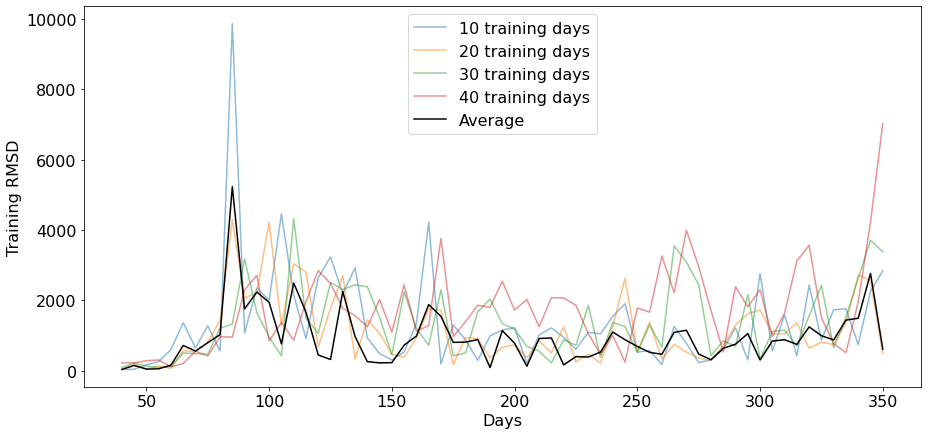

In [72]:
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    
    plt.plot(days, rmsd_val_list[i], alpha=0.5, label=log_paths[i][-12:-10]+" training days")
plt.xlabel("Days")
plt.ylabel("Training RMSD")
plt.plot(days, rmsd_val_avg2, c="k", label="Average")
plt.legend()
plt.show()

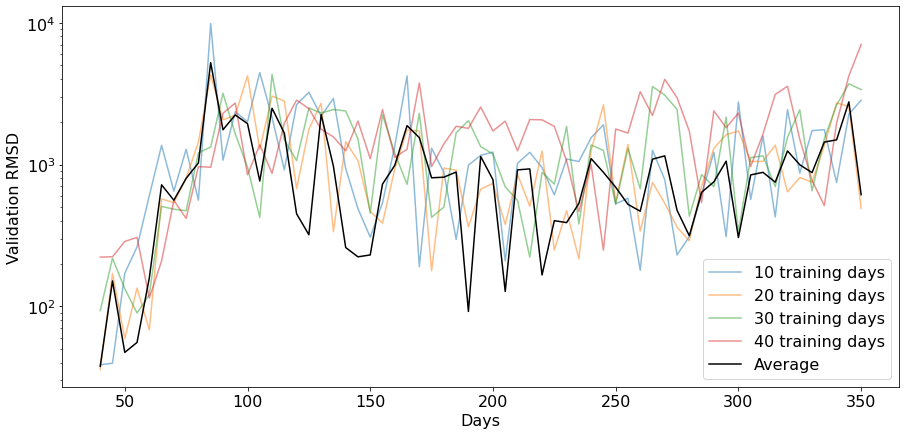

In [73]:
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    
    plt.plot(days, rmsd_val_list[i], alpha=0.5, label=log_paths[i][-12:-10]+" training days")
plt.xlabel("Days")
plt.ylabel("Validation RMSD")
plt.plot(days, rmsd_val_avg2, c="k", label="Average")
plt.legend()
plt.yscale("log")
plt.show()

In [74]:
len(np.where(rmsd_val_avg2 < np.min(rmsd_val_list, axis=0))[0])/len(rmsd_val_avg2)*100

22.22222222222222

Best Validation RMSD for 10 days window: 28.6%
Best Validation RMSD for 20 days window: 34.9%
Best Validation RMSD for 30 days window: 20.6%
Best Validation RMSD for 40 days window: 15.9%


Text(0, 0.5, 'Training window size with best validation RMSD')

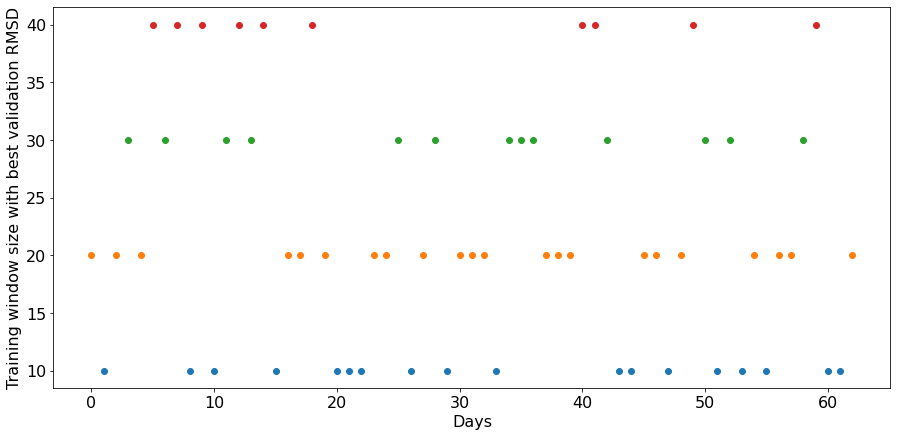

In [75]:
rmsd_val_min = np.array(np.where(rmsd_val_list == np.min(rmsd_val_list, axis=0)))
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    plt.scatter(rmsd_val_min[1][np.where(rmsd_val_min[0] == i)[0]], [int(log_paths[i][-12:-10]) for j in range(len(np.where(rmsd_val_min[0] == i)[0]))])
    print(f"Best Validation RMSD for {log_paths[i][-12:-10]} days window: {len(np.where(rmsd_val_min[0] == i)[0])/len(days)*100:.1f}%")
plt.xlabel("Days")
plt.ylabel("Training window size with best validation RMSD")

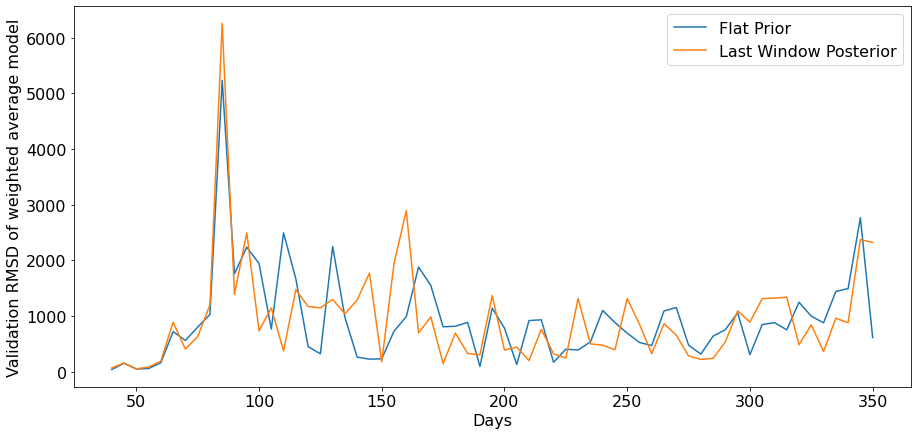

52.38095238095239


In [76]:
plt.figure(figsize=(15,7))
plt.plot(days, rmsd_val_avg2, label="Flat Prior")
plt.plot(days, rmsd_val_avg, label="Last Window Posterior")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Validation RMSD of weighted average model")
plt.show()
print(len(np.where(rmsd_val_avg < rmsd_val_avg2)[0])/len(rmsd_val_avg)*100)

In [77]:
tols2 = np.zeros((len(log_paths), len(days_list[0]), n_post))
tol_median2 = np.zeros((len(log_paths), len(days_list[0]), n_post))
tol_bounds2 = np.zeros((len(log_paths), len(days_list[0]), n_post, 2))

for i in range(len(log_paths)):
    for j in range(len(days_list[i])):
        for k in range(0, n_post):
            
            filepath =  f"{log_paths[i]}Posterior{k+1}/{locations[0]}/{models[0]}/{days_list[i][j]}_days"
            
            logfile = open(filepath+"/SEIRD_log.out").read().split("\n")
            post_tols = np.genfromtxt(filepath+"/post.txt")[:,-1]
            
            for line in logfile:
                
                if "Tolerance:" in line:
#                     print("\t"+line.split(" ")[-1])
                    tols2[i,j,k] = line.split(" ")[-1]
                    tol_median2[i,j,k] = np.median(post_tols)
                    tol_bounds2[i,j,k,0] = np.median(post_tols)-np.min(post_tols)
                    tol_bounds2[i,j,k,1] = np.max(post_tols)-np.median(post_tols)
                    break
            
            print(f"\r{i+1}/{len(log_paths)}, {j+1}/{len(days_list[i])}, {k+1}/{n_post}", end="")

4/4, 63/63, 10/10

In [78]:
# plt.rcParams.update({'font.size': 16})
# for i in range(len(log_paths)):
#     plt.figure(figsize=(30, 10))
#     plt.imshow(np.log10(tols[i][:len(days_list[i])]).T, cmap="coolwarm", aspect=3)
#     plt.yticks(np.arange(10), np.arange(1,11))
#     plt.colorbar(pad=0.01)
#     plt.title(f"Tolerance - {log_paths[i][-12:-10]} days windows")
#     plt.xlabel("Days")
#     plt.ylabel("Posterior")
#     plt.savefig(f"tolerace_heatmap_{log_paths[i][-12:-10]}_noise2vs10.pdf", format="pdf")
#     plt.close()

In [79]:
# plt.rcParams.update({'font.size': 16})
# for i in range(len(log_paths)):
#     plt.figure(figsize=(30, 10))
#     plt.imshow(np.log10(tols2[i][:len(days_list[i])]).T, cmap="coolwarm", aspect=3)
#     plt.yticks(np.arange(10), np.arange(1,11))
#     plt.colorbar(pad=0.01)
#     plt.title(f"Tolerance - {log_paths[i][-12:-10]} days windows")
#     plt.xlabel("Days")
#     plt.ylabel("Posterior")
#     plt.savefig(f"tolerace_heatmap_{log_paths[i][-12:-10]}_noise2vs10_flat.pdf", format="pdf")
#     plt.close()

In [80]:
# plt.rcParams.update({'font.size': 10})

# for j in range(len(log_paths)):
#     plt.subplots(10,7, figsize=(40,28))
#     plt.suptitle(f"Tolerances - {log_paths[j][-12:-10]} days windows", y=1.)

#     for i in range(len(days_list[j])):
#         plt.subplot(7,10,i+1)
# #         plt.plot(np.arange(1, n_post+1), tols[j][i], "-o")
#         plt.errorbar(np.arange(1, n_post+1), tol_median[j,i], tol_bounds[j,i].T, fmt="-o", capsize=7)
#         plt.title(f"Window {i+1}")

#     for i in range(len(days_list[j]), 70):
#         plt.subplot(7,10,i+1)
#         plt.axis("off")

#     plt.suptitle(f"{log_paths[j][-12:-10]} days windows", y=0.93, fontsize=30)
#     plt.savefig(f"tolerances_{log_paths[j][-12:-10]}_noise2vs10.pdf", format="pdf")
#     plt.close()

In [81]:
# plt.rcParams.update({'font.size': 10})

# for j in range(len(log_paths)):
#     plt.subplots(10,7, figsize=(40,28))

#     for i in range(len(days_list[j])):
#         plt.subplot(7,10,i+1)
# #         plt.plot(np.arange(1, n_post+1), tols2[j][i], "-o")
#         plt.errorbar(np.arange(1, n_post+1), tol_median2[j,i], tol_bounds2[j,i].T, fmt="-o", capsize=7)
#         plt.title(f"Window {i+1}")


#     for i in range(len(days_list[j]), 70):
#         plt.subplot(7,10,i+1)
#         plt.axis("off")
    
#     plt.suptitle(f"{log_paths[j][-12:-10]} days windows", y=0.93, fontsize=30)
#     plt.savefig(f"tolerances_{log_paths[j][-12:-10]}_noise2vs10_flat.pdf", format="pdf")
#     plt.close()

In [84]:
plt.rcParams.update({'font.size': 10})

for j in range(len(log_paths)):
    plt.subplots(10,7, figsize=(40,28))

    for i in range(len(days_list[j])):
        plt.subplot(7,10,i+1)
#         plt.plot(np.arange(1, n_post+1), tols2[j][i], "-o")
#         plt.plot(np.arange(1, n_post+1), tols[j][i], "-o")
        plt.errorbar(np.arange(1, n_post+1), tol_median2[j,i], tol_bounds2[j,i].T, fmt="-o", capsize=7)
        plt.errorbar(np.arange(1, 5+1), tol_median[j,i], tol_bounds[j,i].T, fmt="-o", capsize=7)
        plt.title(f"Window {i+1}")
    #     plt.title()

    for i in range(len(days_list[j]), 70):
        plt.subplot(7,10,i+1)
        plt.axis("off")
        
    plt.suptitle(f"{log_paths[j][-12:-10]} days windows. Blue = flat prior; orange = last window posterior", y=0.93, fontsize=30)
    plt.savefig(f"tolerances_{log_paths[j][-12:-10]}_noise2vs10_comparison.pdf", format="pdf")
    plt.close()

In [85]:
plt.rcParams.update({'font.size': 10})

for j in range(len(log_paths)):
    plt.subplots(10,7, figsize=(40,28))

    for i in range(len(days_list[j])):
        plt.subplot(7,10,i+1)
#         plt.plot(np.arange(1, n_post+1), tols2[j][i], "-o")
#         plt.plot(np.arange(1, n_post+1), tols[j][i], "-o")
        plt.errorbar(np.arange(1, n_post+1), tol_median2[j,i], tol_bounds2[j,i].T, fmt="-o", capsize=7)
        plt.errorbar(np.arange(1, 5+1), tol_median[j,i], tol_bounds[j,i].T, fmt="-o", capsize=7)
        plt.yscale("log")
        plt.title(f"Window {i+1}")
    #     plt.title()

    for i in range(len(days_list[j]), 70):
        plt.subplot(7,10,i+1)
        plt.axis("off")
        
    plt.suptitle(f"{log_paths[j][-12:-10]} days windows. Blue = flat prior; orange = last window posterior", y=0.93, fontsize=30)
    plt.savefig(f"tolerances_{log_paths[j][-12:-10]}_noise2vs10_comparison_log.pdf", format="pdf")
    plt.close()